In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os,cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout,Rescaling, Flatten
from sklearn.metrics import confusion_matrix

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [6]:
base_dir = 'Capstone/train/'

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
labels=[]
for folder in os.listdir(base_dir):
    labels.append(folder)
labels.sort()
labels = labels[0:13]
print(labels)

['bow pose', 'camel pose', 'chair pose', 'dancer pose', 'downward dog', 'easy pose', 'half pigeon pose', 'high plank', 'pendant pose', 'plow pose', 'side plank', 'staff pose', 'tree pose']


In [10]:
train_images=[]
train_labels=[]

for i,folder in enumerate(labels):
    try:
        for image in os.listdir(base_dir+'/'+folder):
            img = os.path.join(base_dir+'/'+folder+'/'+image)
            img = cv2.imread(img)
            img = cv2.resize(img,(256,256))
            train_images.append(img)
            train_labels.append(i)
    except:
        print(i,folder,image,img)
train_images = np.asarray(train_images)
train_labels = np.asarray(train_labels).astype('int64')

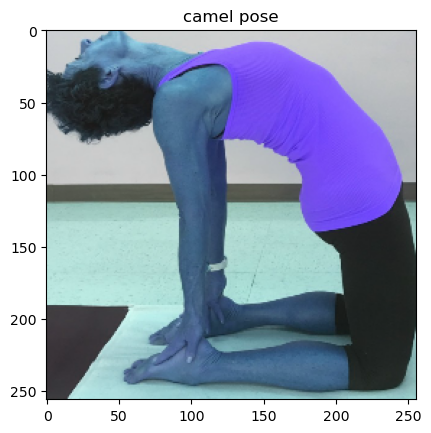

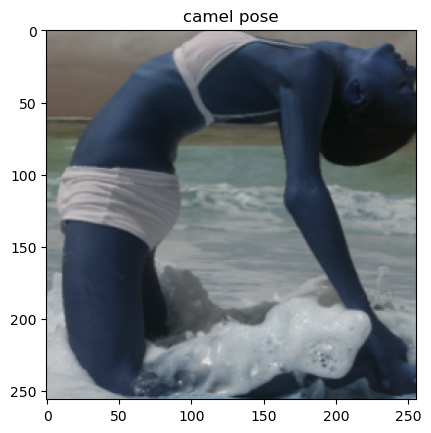

In [11]:
for i in [300,400]:
    plt.imshow(train_images[i])
    plt.title(labels[train_labels[i]])
    plt.show()

In [12]:
train_labels = to_categorical(train_labels, 13)

In [13]:
X_train,X_test,y_train,y_test = train_test_split(train_images,train_labels,test_size=0.1,shuffle=True)

In [16]:
model = tf.keras.models.Sequential([
            tf.keras.Input(shape=(256,256,3)),
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            Rescaling(1.0 / 255),
            Conv2D(32,(3,3),activation='relu'),
            MaxPooling2D((2,2)),
            Dropout(0.3),
            Conv2D(64,(3,3),activation='relu'),
            MaxPooling2D((2,2)),
            Dropout(0.3),
            Conv2D(64,(3,3),activation='relu'),
            MaxPooling2D((2,2)),
            Dropout(0.5),
            Flatten(),
            Dense(512,activation='relu'),
            Dense(128,activation='relu'),
            Dense(13,activation='softmax')
])

In [17]:
model.compile(optimizer='adam',
              loss= tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy']
            )

history = model.fit(X_train, y_train,
          batch_size=32, epochs=25, validation_split=0.2)

Epoch 1/25
70/70 [==============================] - 196s 3s/step - loss: 3.0987 - accuracy: 0.0834 - val_loss: 2.5643 - val_accuracy: 0.0757
Epoch 2/25
70/70 [==============================] - 226s 3s/step - loss: 2.4943 - accuracy: 0.1344 - val_loss: 2.4222 - val_accuracy: 0.2991
Epoch 3/25
70/70 [==============================] - 190s 3s/step - loss: 2.0988 - accuracy: 0.3135 - val_loss: 1.7686 - val_accuracy: 0.4595
Epoch 4/25
70/70 [==============================] - 213s 3s/step - loss: 1.7300 - accuracy: 0.4741 - val_loss: 1.4259 - val_accuracy: 0.5982
Epoch 5/25
70/70 [==============================] - 158s 2s/step - loss: 1.5067 - accuracy: 0.5277 - val_loss: 1.2384 - val_accuracy: 0.6000
Epoch 6/25
70/70 [==============================] - 163s 2s/step - loss: 1.3738 - accuracy: 0.5837 - val_loss: 1.2393 - val_accuracy: 0.6216
Epoch 7/25
70/70 [==============================] - 190s 3s/step - loss: 1.2341 - accuracy: 0.6184 - val_loss: 0.9253 - val_accuracy: 0.7495
Epoch 8/25
70

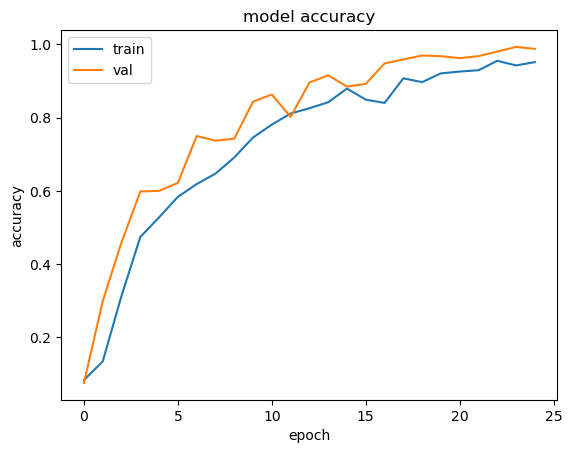

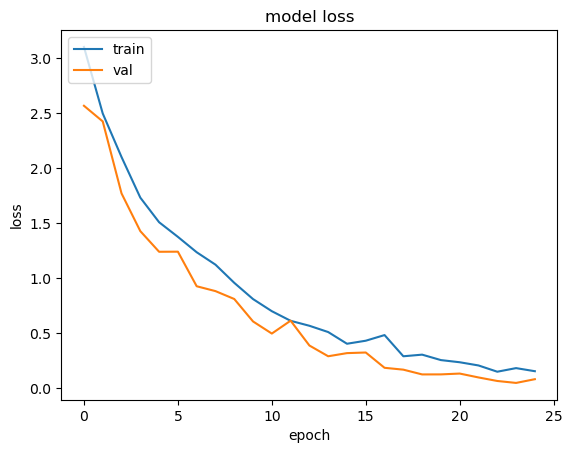

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Transfer Learning - MobileNet

In [19]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(256, 256, 3),
                                                include_top=False,
                                                weights='imagenet')

In [22]:
base_model.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dense(512,activation='relu')(x)

outputs = tf.keras.layers.Dense(13,activation='softmax')(x) #len(class_info)
model = tf.keras.Model(inputs = base_model.input, outputs = outputs)

In [23]:
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 128, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 128, 128, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 128, 128, 32)         0         ['bn_Conv1[0][0]']      

In [24]:
#Model compile with Adam optimizer, and categorical_crossentropy for the loss
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

In [25]:
#Start training the model, and save the history
history = model.fit(X_train, y_train,
          batch_size=32, epochs=20, validation_split=0.2)

Epoch 1/20
70/70 [==============================] - 291s 4s/step - loss: 1.0131 - accuracy: 0.7754 - val_loss: 0.8355 - val_accuracy: 0.7441
Epoch 2/20
70/70 [==============================] - 295s 4s/step - loss: 0.0079 - accuracy: 0.9995 - val_loss: 0.3685 - val_accuracy: 0.9117
Epoch 3/20
70/70 [==============================] - 335s 5s/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.2944 - val_accuracy: 0.9189
Epoch 4/20
 7/70 [==>...........................] - ETA: 4:13 - loss: 0.0013 - accuracy: 1.0000

KeyboardInterrupt: 

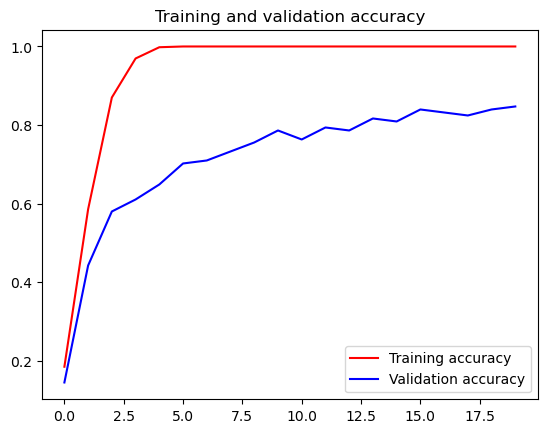

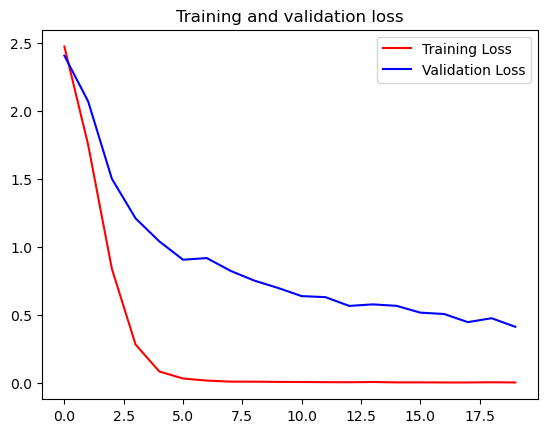

In [23]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
#Save the model in google colab temporary storage
model_name = 'yoga model3.h5'

model.save(model_name)

In [25]:
#Import files from google.colab library to download model
from google.colab import files
files.download(model_name)

ModuleNotFoundError: No module named 'google.colab'

In [26]:
imported_model = tf.keras.models.load_model("yoga model3.h5")

OSError: No file or directory found at yoga model3.h5

In [28]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('YouGo.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\HAFIZI~2\AppData\Local\Temp\tmpcfrku7l_\assets


INFO:tensorflow:Assets written to: C:\Users\HAFIZI~2\AppData\Local\Temp\tmpcfrku7l_\assets
